In [1]:
# ライブラリインポート

## 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 分解
import scipy.stats
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
import my_function

## 学習
from esn_model import ESN, Tikhonov
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# データ読み込み

## csv読み込み
df = pd.read_csv('./available_csv/AirPassengers.csv')
print(df.head())

## データ整形（必要であれば）
df = df['Passengers']
print(df.head())

        Month  Passengers
0  1949-01-01         112
1  1949-02-01         118
2  1949-03-01         132
3  1949-04-01         129
4  1949-05-01         121
0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64


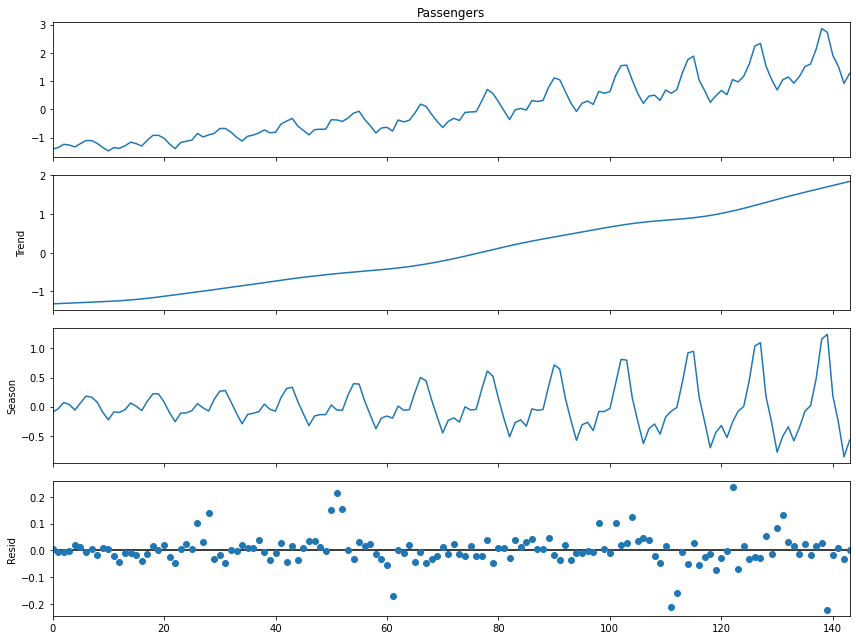

In [3]:
# 分解

## 正規化
raw_array = scipy.stats.zscore(df)

## STL分解
stl=STL(raw_array, period=12, robust=True)
stl_series = stl.fit()

## STL分解結果のグラフ化
plt.rcParams['figure.figsize'] = [12, 9]
stl_series.plot()
plt.show()

## データの整形
### default : SlideingWindow = 5
raw_x, raw_y = my_function.sliding_window(raw_array)
trend_x, trend_y = my_function.sliding_window(stl_series.trend)
seasonal_x, seasonal_y = my_function.sliding_window(stl_series.seasonal)
resid_x, resid_y = my_function.sliding_window(stl_series.resid)

## データの分割
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(raw_x, raw_y, test_size=0.1, shuffle=False)
trend_x_train, trend_x_test, trend_y_train, trend_y_test = train_test_split(trend_x, trend_y, test_size=0.1, shuffle=False)
seasonal_x_train, seasonal_x_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_x, seasonal_y, test_size=0.1, shuffle=False)
resid_x_train, resid_x_test, resid_y_train, resid_y_test = train_test_split(resid_x, resid_y, test_size=0.1, shuffle=False)

In [4]:
# 学習

## ハイパーパラメータ
N_x = 10

## 単体学習
### トレンド学習
trend_esn_model = ESN(trend_x_train.shape[1], 1, N_x, density=0.05, input_scale=1.0, rho=0.8, leaking_rate=1.0)
trend_esn_model.train(trend_x_train, trend_y_train, Tikhonov(N_x, 1, 0.0))
### 季節性学習
seasonal_model = ESN(seasonal_x_train.shape[1], 1, N_x, density=0.05, input_scale=1.0, rho=0.8, leaking_rate=1.0)
seasonal_model.train(seasonal_x_train, seasonal_y_train, Tikhonov(N_x, 1, 0.0))
### 残差学習
resid_reg = DecisionTreeRegressor()
resid_cart_model = resid_reg.fit(resid_x_train, resid_y_train)

## 結合学習
### 足し合わせ
lr_np_train = np.concatenate([trend_esn_model.predict(trend_x_train),
                    seasonal_model.predict(seasonal_x_train).reshape(-1, 1),
                    resid_cart_model.predict(resid_x_train).reshape(-1, 1)], 1)
lr_df_train = pd.DataFrame(lr_np_train)
lr_pred_train = lr_df_train.sum(axis = 1)

In [5]:
# 予測

## 単体予測
trend_esn_pred = trend_esn_model.predict(trend_x_test)
seasonal_pred = seasonal_model.predict(seasonal_x_test)
resid_cart_pred = resid_cart_model.predict(resid_x_test).reshape(-1, 1)

## 結合予測
lr_np_test = np.concatenate([trend_esn_pred,
                            seasonal_pred,
                            resid_cart_pred], 1)
lr_df_test = pd.DataFrame(lr_np_test)
lr_pred_test = lr_df_test.sum(axis = 1)

In [6]:
lr_df_test

,0,1,2
0,1.367896,-0.298427,0.010427
1,1.404536,-0.554850,0.100807
2,1.441719,-0.154078,0.035856
3,1.478185,-0.186561,-0.031429
4,1.513661,-0.118968,0.038150
5,1.549039,-0.224204,-0.044494
6,1.571608,0.071385,-0.055713
7,1.606537,0.259649,-0.022220
8,1.640323,0.631991,0.017311
9,1.673318,1.043921,-0.011361


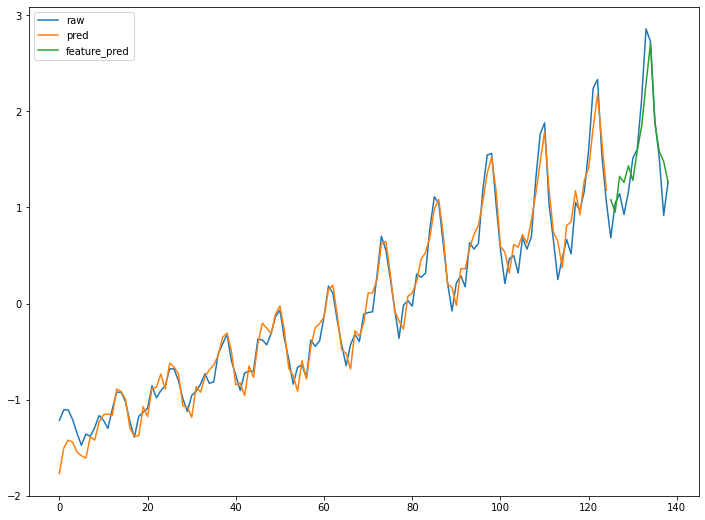

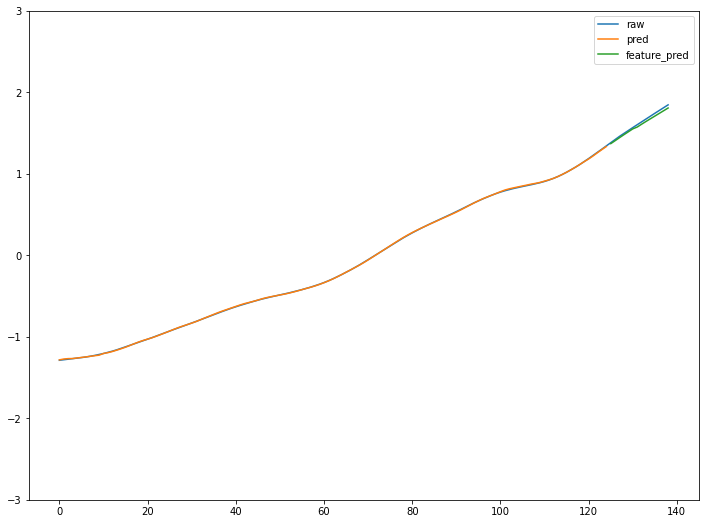

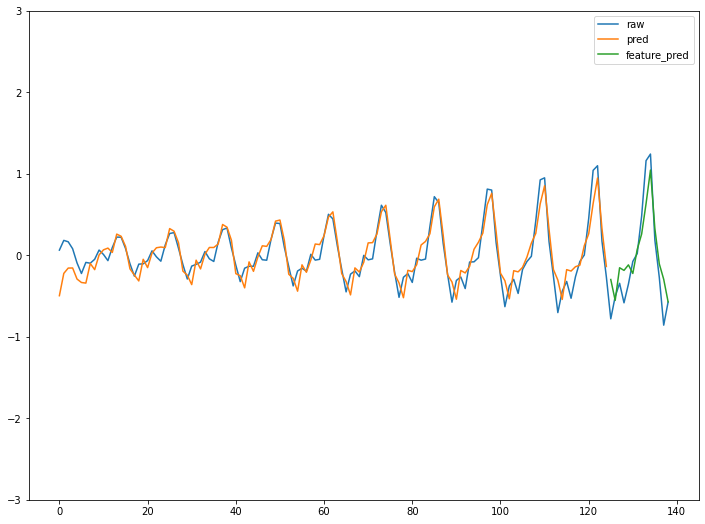

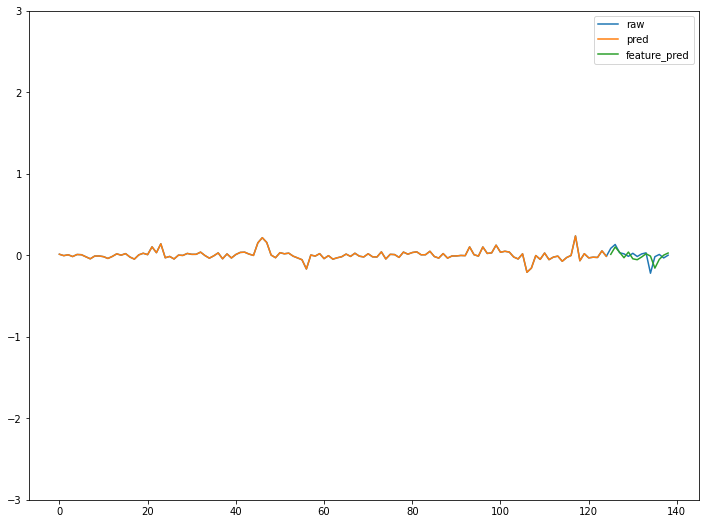

In [7]:
# 評価

## 全体
plt.figure()
plt.plot(raw_y, label='raw')
plt.plot(lr_pred_train, label='pred')
plt.plot(range((len(raw_y)-len(lr_pred_test)),len(raw_y)),lr_pred_test, label='feature_pred')
plt.legend()
plt.show()

## トレンド
plt.figure()
plt.plot(trend_y, label='raw')
plt.plot(lr_df_train[0], label='pred')
plt.plot(range((len(trend_y)-len(trend_esn_pred)),len(trend_y)),trend_esn_pred, label='feature_pred')
plt.ylim(-3,3)
plt.legend()
plt.show()

## 季節性
plt.figure()
plt.plot(seasonal_y, label='raw')
plt.plot(lr_df_train[1], label='pred')
plt.plot(range((len(seasonal_y)-len(seasonal_pred)),len(seasonal_y)),seasonal_pred, label='feature_pred')
plt.ylim(-3,3)
plt.legend()
plt.show()

## 残差
plt.figure()
plt.plot(resid_y, label='raw')
plt.plot(lr_df_train[2], label='pred')
plt.plot(range((len(resid_y)-len(resid_cart_pred)),len(resid_y)),resid_cart_pred, label='feature_pred')
plt.ylim(-3,3)
plt.legend()
plt.show()

In [8]:
from sklearn.tree import DecisionTreeRegressor,plot_tree

plt.figure(figsize=(12,12))
plot_tree(
    resid_cart_model,
    filled=True, rounded=True
)
plt.show()

NameError: name 'seasonal_cart_model' is not defined

<Figure size 864x864 with 0 Axes>